In [1]:
!pip install scikit-learn
!pip install pandas
!pip install matplotlib

  Using cached scikit_learn-1.2.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.8 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Using cached joblib-1.2.0-py3-none-any.whl (297 kB)
  Using cached pandas-2.0.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
  Using cached pytz-2023.3-py2.py3-none-any.whl (502 kB)
  Using cached matplotlib-3.7.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.2 MB)
  Using cached contourpy-1.0.7-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (300 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cache

In [2]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

df = pd.read_csv("Joules_of_Siam_Data - Dataset_Strech.csv")
df.head()

,Year,Month,Population,Temperature,CPI,Peak
0,2022,12,66.090000,26.300000,106.470000,27124.7
1,2022,11,66.083333,26.249167,106.470000,27832.7
2,2022,10,66.076667,26.198333,106.470000,27041.9
3,2022,9,66.070000,26.147500,106.470000,27808.0
4,2022,8,66.063333,26.096667,108.503333,28951.8


In [4]:
df.shape

(252, 6)

In [5]:
df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2)

In [6]:
X = df[['Date','Peak']]
X.head()

,Date,Peak
0,2022-12,27124.7
1,2022-11,27832.7
2,2022-10,27041.9
3,2022-09,27808.0
4,2022-08,28951.8


In [7]:
X = X.iloc[::-1]
X = X.reset_index(drop=False)
X.drop(columns = ['index'], inplace=True)
X.set_index('Date', inplace=True)
X.head()

,Peak
Date,
2002-01,14552.5
2002-02,15260.8
2002-03,16485.3
2002-04,16681.1
2002-05,16293.1


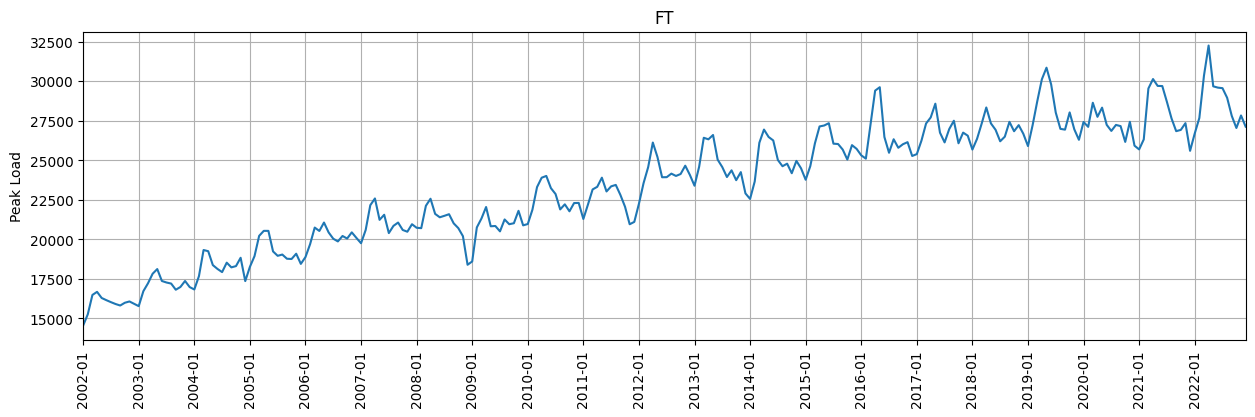

In [8]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.xticks(X.index[::12], rotation=90)
plt.show()

In [9]:
y = X.Peak.values.astype(float)

test_size = 24
window_size = 24

train_set = y[:-test_size]
test_set  = y[-test_size:]

print(f'Train: {len(train_set)}')
print(f'Test:  {len(test_set)}')

Train: 228
Test:  24


In [10]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform(train_set.reshape(-1, 1))

print(f'First item, original: {train_set[0]}')
print(f'First item, scaled: {train_norm[0]}')

First item, original: 14552.5
First item, scaled: [-1.]


In [11]:
train_norm = torch.FloatTensor(train_norm).view(-1)

def input_data(seq, ws):
    out = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        out.append((window,label))
    return out

In [12]:
train_data = input_data(train_norm,window_size)

print(f'Train_data: {len(train_data)}')

Train_data: 204


In [26]:
class LSTMnetwork(nn.Module):
    def __init__(self,input_size=1,hidden_size=64,output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        # Add an LSTM layer:
        self.lstm = nn.LSTM(input_size,hidden_size)
        
        # Add a fully-connected layer:
        self.linear = nn.Linear(hidden_size,output_size)
        
        # Initialize h0 and c0:
        self.hidden = (torch.zeros(1,1,self.hidden_size),
                       torch.zeros(1,1,self.hidden_size))

    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(
            seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(101)
model = LSTMnetwork().to(device)
model

cuda


LSTMnetwork(
  (lstm): LSTM(1, 64)
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

In [27]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Training 

In [31]:
epochs = 5000

for i in range(epochs):
    for seq, y_train in train_data:
        
        seq = seq.to(device)
        y_train = y_train.to(device)
        # reset the parameters and hidden states
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        
        # apply the model
        y_pred = model(seq)

        # update parameters
        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
        
    if (i+1) % 100 == 0:
        # OPTIONAL print statement
        print(f'{i+1} of {epochs} epochs completed')

100 of 5000 epochs completed
200 of 5000 epochs completed
300 of 5000 epochs completed
400 of 5000 epochs completed
500 of 5000 epochs completed
600 of 5000 epochs completed
700 of 5000 epochs completed
800 of 5000 epochs completed
900 of 5000 epochs completed
1000 of 5000 epochs completed
1100 of 5000 epochs completed
1200 of 5000 epochs completed
1300 of 5000 epochs completed
1400 of 5000 epochs completed
1500 of 5000 epochs completed
1600 of 5000 epochs completed
1700 of 5000 epochs completed
1800 of 5000 epochs completed
1900 of 5000 epochs completed
2000 of 5000 epochs completed
2100 of 5000 epochs completed
2200 of 5000 epochs completed
2300 of 5000 epochs completed
2400 of 5000 epochs completed
2500 of 5000 epochs completed
2600 of 5000 epochs completed
2700 of 5000 epochs completed
2800 of 5000 epochs completed
2900 of 5000 epochs completed
3000 of 5000 epochs completed
3100 of 5000 epochs completed
3200 of 5000 epochs completed
3300 of 5000 epochs completed
3400 of 5000 epochs

## Testing 

In [36]:
future = 24 #months
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future): #future
    seq = torch.FloatTensor(preds[-window_size:]).to(device)
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device),
                        torch.zeros(1,1,model.hidden_size).to(device))
        preds.append(model(seq).item())
        
# preds[window_size:]

In [37]:
true_predictions = scaler.inverse_transform(np.array(preds[window_size:]).reshape(-1, 1))
# true_predictions = true_predictions.astype(str).tolist()

In [38]:
true_predictions = true_predictions.reshape(-1)

In [39]:
day = np.arange('2021-01', '2023-01', dtype='datetime64[M]') #.astype('datetime64[D]')
day = day.astype(str).tolist()

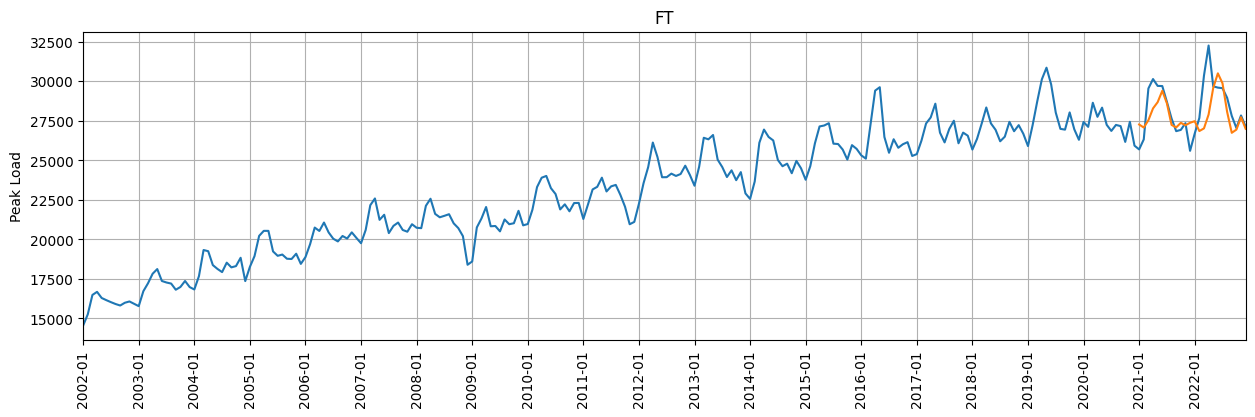

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.plot(day, true_predictions)
plt.xticks(X.index[::12], rotation=90)
plt.show()

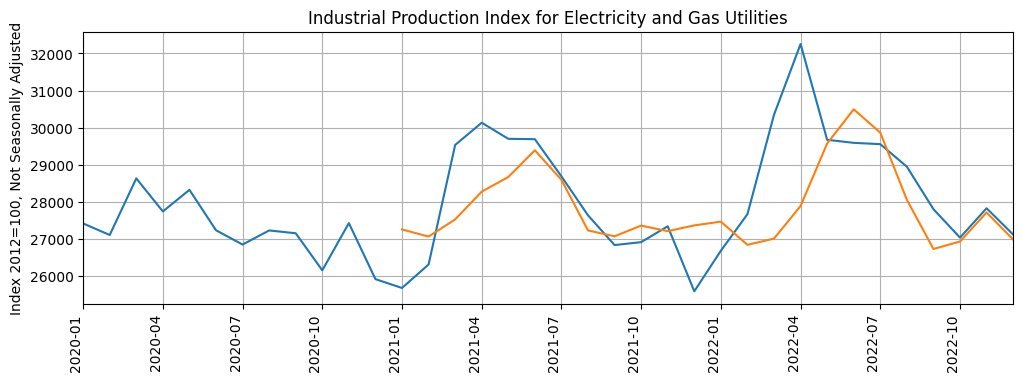

In [41]:
fig = plt.figure(figsize=(12,4))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100, Not Seasonally Adjusted')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()
plt.plot(X['Peak']['2020-01':])
plt.plot(day, true_predictions)
plt.xticks(X['Peak']['2020-01':].index[::3], rotation=90)
plt.show()

In [42]:
test_set

array([25686.2, 26318.8, 29536.8, 30135.3, 29702. , 29692.1, 28690.5,
       27642.1, 26841.2, 26920.4, 27346.9, 25596.9, 26688.4, 27672.5,
       30349. , 32254.5, 29675.3, 29593.6, 29558.1, 28951.8, 27808. ,
       27041.9, 27832.7, 27124.7])

In [43]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

MSE  = mean_squared_error(test_set, true_predictions)
RMSE = math.sqrt(MSE)
MAE  = mean_absolute_error(test_set, true_predictions)

MSE, RMSE, MAE

(2065559.7101606408, 1437.2055211975219, 980.3905898759767)

## Inference 

In [ ]:
future = 84 #months
preds = train_norm[-window_size:].tolist()

model.eval()

for i in range(future): #future
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        preds.append(model(seq).item())
        
# preds[window_size:]

In [ ]:
true_predictions = scaler.inverse_transform(np.array(preds[-future:]).reshape(-1, 1))
# true_predictions = true_predictions.astype(str).tolist()

In [ ]:
true_predictions = true_predictions.reshape(-1)
true_predictions.shape

(84,)

In [ ]:
day = np.arange('2021-01', '2028-01', dtype='datetime64[M]') #.astype('datetime64[D]')
day = day.astype(str).tolist()
len(day)

84

In [ ]:
day[::12]

['2021-01', '2022-01', '2023-01', '2024-01', '2025-01', '2026-01', '2027-01']

In [ ]:
total = X.index[::12].values.tolist() + day[::12]

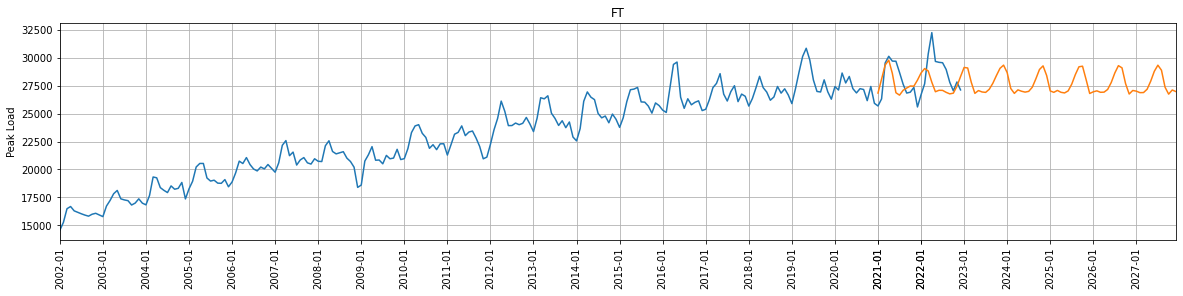

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.title('FT')
plt.ylabel('Peak Load')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(X)
plt.plot(day, true_predictions)
plt.xticks(total, rotation=90)
plt.show()